In [61]:
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd
import numpy as np

In [62]:
data_path = 'output_data/btes_base_case_orca/'

color_map = {
    'solar': '#FDB845',
    'wind': '#74CBCA',
    'battery': '#6F4E7C',
    'natgas': 'gray',
    'oil': 'black',
    'hydrogen': '#F6A3AD',
    'BTES': '#BF3B3D',
    'load': '#0B84A5',
    'lost_load': '#9DD866',}

In [63]:
def get_cost_contributions(datapath, filename):
    """
    Get the cost contributions of the different technologies from the pickle file.
    """
    with open(os.path.join(datapath, filename), 'rb') as f:
        data = pickle.load(f)

        component_data = data['component results']
        # Add by carrier
        component_data_carrier = component_data.groupby('carrier').sum()
        cost = component_data_carrier['Capital Expenditure [$]'] + component_data_carrier['Operational Expenditure [$]']
        # Divide by total met demand i.e. withdrawal of load
        total_met_demand = component_data['Withdrawal [MW]']['Load'].sum()
        # Drop load
        cost = cost.drop('load')
        # Group BTES_charger, BTES_discharger and granite into BTES
        cost = cost.groupby(lambda x: 'BTES' if ('BTES' in x or 'granite' in x) else x).sum()
    # Close the file
    f.close()
    return cost, total_met_demand
            

In [64]:
def get_energy_stored(result_data, mean_demand):
    """
    Get the energy stored in the different storage technologies.
    """
    # Average over 5 days
    result_data['time results'] = result_data['time results'].resample('5D').mean()

    energy_stored_btes = result_data['time results']['granite e']/mean_demand
    energy_stored_hydrogen = result_data['time results']['hydrogen storage underground e']/mean_demand
    energy_stored_battery = result_data['time results']['Lithium-Ion-LFP-store e']/mean_demand

    return energy_stored_btes, energy_stored_hydrogen, energy_stored_battery

In [65]:
def get_sources_sinks(result_data, mean_demand):
    """
    Get the electricity sources and sinks of the system.
    """
    # Get all dispatch data
    dispatch = result_data['time results'].filter(like='dispatch').rename(columns=lambda x: x.replace(' dispatch', ''))
    # Rename with key in color_map if it exists
    dispatch = dispatch.rename(columns={'solar-utility': 'solar', 'onwind':'wind', 'CCGT':'natgas'})

    # Dispatch sources are all except electrolysis, battery charger, BTES charger; and load
    dispatch_sources = dispatch.drop(['electrolysis', 'Lithium-Ion-LFP-bicharger', 'BTES_charger'], axis=1)
    # Rename dispatch sources
    dispatch_sources = dispatch_sources.rename(columns={'fuel cell': 'hydrogen', 'Lithium-Ion-LFP-bicharger % discharge': 'battery', 'BTES_discharger':'BTES'})
    dispatch_sources /= mean_demand
    # Order columns by decreasing integral
    dispatch_sources = dispatch_sources[dispatch_sources.sum().sort_values(ascending=False).index]

    # Dispatch sinks are electrolysis, battery charger, BTES charger; and load
    dispatch_chargers = dispatch[['electrolysis', 'Lithium-Ion-LFP-bicharger', 'BTES_charger']]
    load = result_data['time results']['load load']
    dispatch_sinks = pd.concat([load, dispatch_chargers], axis=1)
    dispatch_sinks = dispatch_sinks.rename(columns={'load load': 'load', 'electrolysis': 'hydrogen', 'Lithium-Ion-LFP-bicharger': 'battery', 'BTES_charger': 'BTES'})
    dispatch_sinks = (dispatch_sinks/mean_demand) * (-1)
    # Order columns by increasing integral
    dispatch_sinks = dispatch_sinks[dispatch_sinks.sum().sort_values(ascending=True).index]
    
    return dispatch_sources, dispatch_sinks

In [66]:
def plot_cost_scan(data_path, region, tech):
    """
    Plot the cost scan of the BTES discharge cost.
    """
    plt.figure()
    system_cost = []
    file_names = [f for f in os.listdir(data_path) if (f.endswith('.pickle') and tech in f)]
    for btes_file in file_names:

        btes_discharge_cost = btes_file.split('_')[-1].split('.')[0]
        btes_discharge_cost = btes_discharge_cost.replace('costsx', '').replace('p', '.')

        syst_cost, demand = get_cost_contributions(data_path, btes_file)
        cost_per_demand = syst_cost / demand
        system_cost.append((float(btes_discharge_cost)*100, cost_per_demand))

    # Sort by cost factor
    system_cost = sorted(system_cost, key=lambda x: float(x[0]))
    
    # Collect data for stackplot
    x_values = []
    stack_data = {}
    for x_value, cost in system_cost:
        # Sort cost components
        cost = cost.sort_values(ascending=False)
        x_values.append(x_value)
        for name, cost_value in cost.items():
            if name not in stack_data:
                stack_data[name] = []
            stack_data[name].append(cost_value)
    # Prepare data for stackplot
    stack_labels = list(stack_data.keys())
    stack_values = [stack_data[label] for label in stack_labels]

    # Calculate total area for each cost component
    stack_areas = {label: sum(values) for label, values in zip(stack_labels, stack_values)}

    # Sort labels and corresponding values by total area (descending)
    sorted_stack_labels = sorted(stack_areas.keys(), key=lambda label: stack_areas[label], reverse=True)
    sorted_stack_values = [stack_data[label] for label in sorted_stack_labels]

    # Plot stacked area
    plt.stackplot(
        x_values,
        *sorted_stack_values,
        labels=sorted_stack_labels,
        colors=[color_map[label] for label in sorted_stack_labels]
    )

    # x-axis
    plt.xlabel('of current {} costs'.format(tech if tech != 'BTES' else 'underground thermal storage'), fontsize=16)
    plt.xticks(ticks=[0, 20, 40, 60, 80, 100, 120, 140, 160], labels=[str(i) + '%' for i in [0, 20, 40, 60, 80, 100, 120, 140, 160]], fontsize=13)
    plt.xlim(0, 165)
    # y-axis
    plt.ylabel('System cost\n[$/MWh met demand]', fontsize=16)
    plt.yticks(fontsize=13)
    plt.ylim(0, 55)

    # Add legend with unique names
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = [label.replace('_', ' ') for label in labels]
    by_label = dict(zip(labels, handles))
    # Put legend outside of plot
    plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)
    if not os.path.exists('figures/{0}'.format(region)):
        os.makedirs('figures/{0}'.format(region))
    plt.savefig('figures/{0}/cost_scan_{1}.pdf'.format(region, tech), bbox_inches='tight')

In [67]:
def make_storage_plots(data_file, cost, reg, scan_var):
    """
    Make plots for energy in storage and charge/discharge power
    """

    with open(data_file, 'rb') as f:
        result_data = pickle.load(f)
    f.close()

    mean_demand = result_data['time results']['load load'].mean()
    energy_stored_btes, energy_stored_hydrogen, energy_stored_battery = get_energy_stored(result_data, mean_demand)
    dispatch_sources, dispatch_sinks = get_sources_sinks(result_data, mean_demand)

    # Create subplots where one shows energy and the other charge/discharge power
    # Create figure for energy stored
    plt.figure()
    plt.plot(energy_stored_btes.index, energy_stored_btes, color=color_map['BTES'], label='BTES')
    plt.plot(energy_stored_hydrogen.index, energy_stored_hydrogen, color=color_map['hydrogen'], label='hydrogen')
    plt.plot(energy_stored_battery.index, energy_stored_battery, color=color_map['battery'], label='battery')
    # x-axis
    plt.xlabel('Date', fontsize=16)
    plt.xticks(fontsize=13, rotation=45)
    plt.xlim(energy_stored_btes.index[0], energy_stored_btes.index[-1])
    # y-axis
    plt.ylabel('Energy stored per\nmean demand [MWh/MW]', fontsize=16)
    plt.yticks(fontsize=13)
    plt.ylim(0, 2200)
    # Legend
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)
    plt.title(f"{scan_var}")
    # Save figure
    plt.savefig('figures/{0}/energy_stored_{1}_{2}.pdf'.format(reg, scan_var.split(" ")[0], cost), bbox_inches='tight')

    # Create figure for dispatch sources and sinks
    plt.figure()
    y_sources = np.vstack([source for source in dispatch_sources.values.T])
    y_sinks = np.vstack([sink for sink in dispatch_sinks.values.T])
    plt.stackplot(dispatch_sources.index, y_sources, colors=[color_map[source] for source in dispatch_sources.columns], labels=dispatch_sources.columns)
    plt.stackplot(dispatch_sinks.index, y_sinks, colors=[color_map[sink] for sink in dispatch_sinks.columns], labels=dispatch_sinks.columns)
    # x-axis
    plt.xlabel('Date', fontsize=16)
    plt.xticks(fontsize=13, rotation=45)
    plt.xlim(energy_stored_btes.index[0], energy_stored_btes.index[-1])
    # y-axis
    plt.ylabel('Dispatch per\nmean demand [MW/MW]', fontsize=16)
    plt.yticks(fontsize=13)
    plt.ylim(-2, 2)
    # Legend
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = [label.replace('_', ' ') for label in labels]
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)
    # Save figure
    plt.savefig('figures/{0}/dispatch_{1}_{2}.pdf'.format(reg, scan_var.split(" ")[0], cost), bbox_inches='tight')

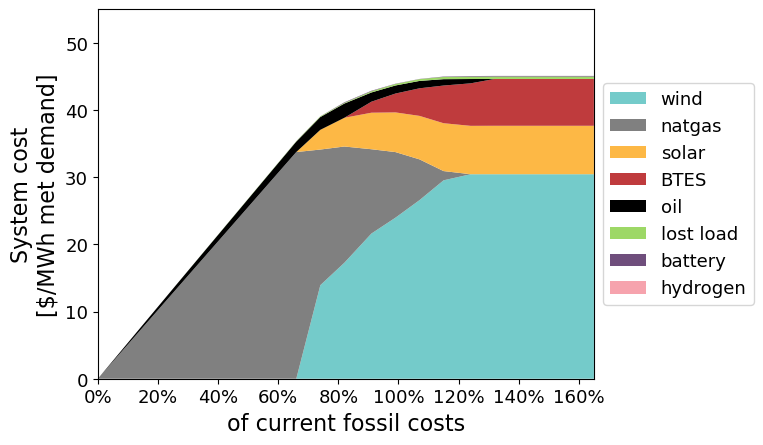

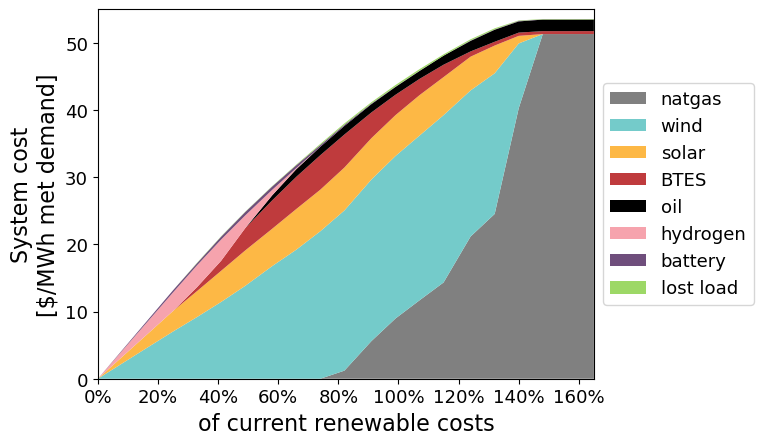

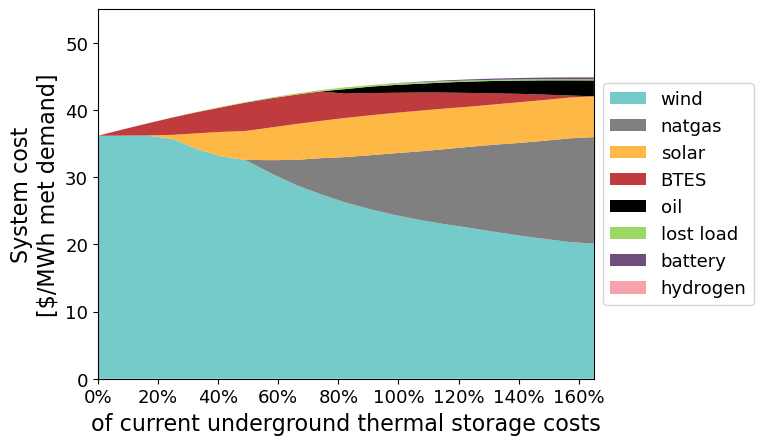

In [68]:
for tech in ['fossil', 'renewable','BTES']:
    plot_cost_scan(data_path, "conus", tech)

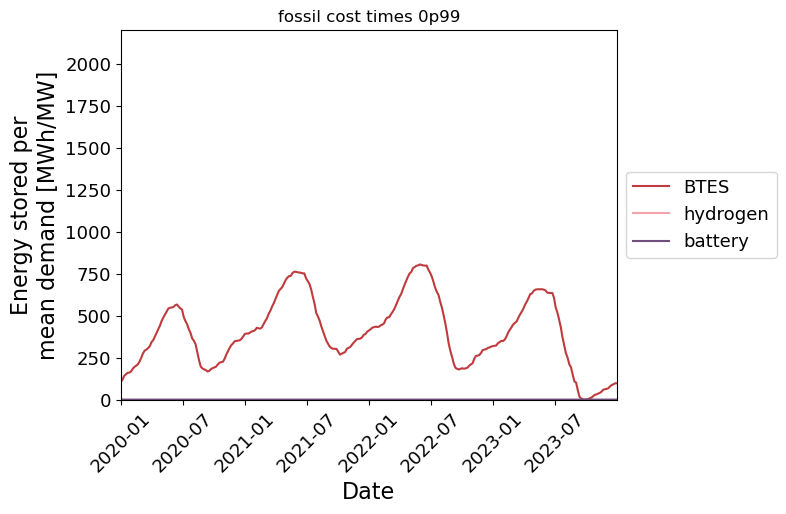

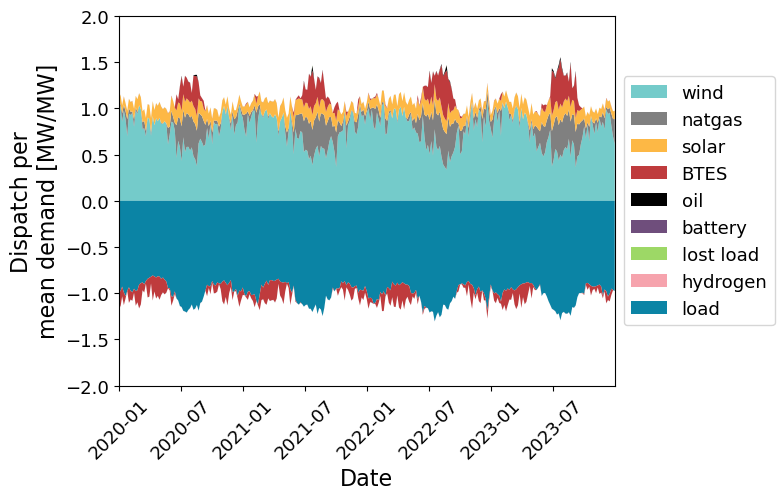

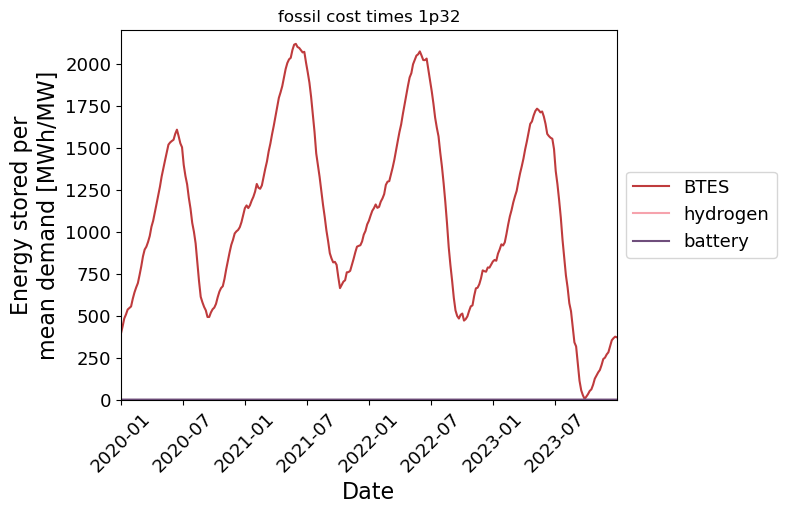

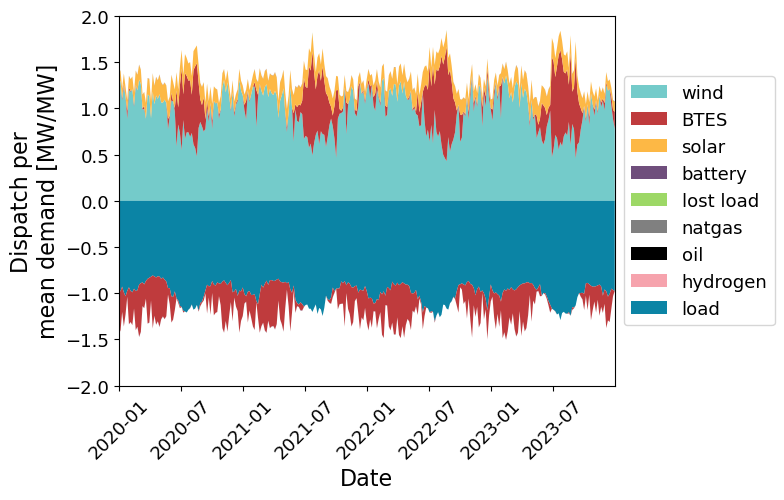

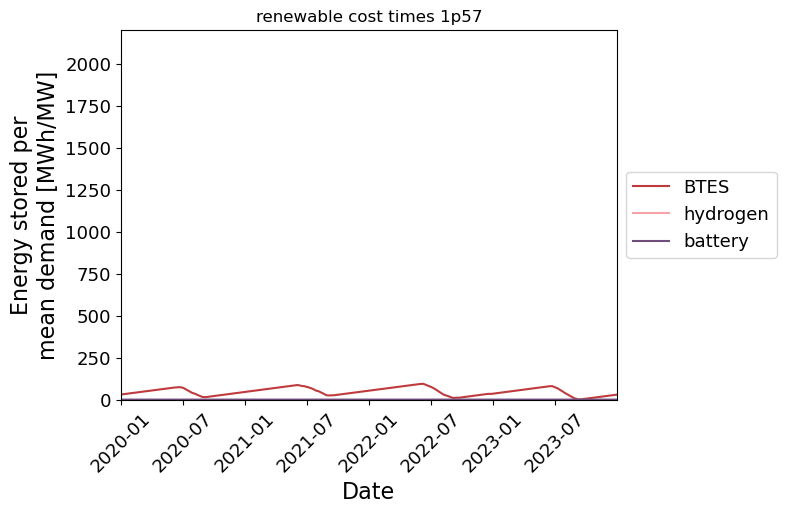

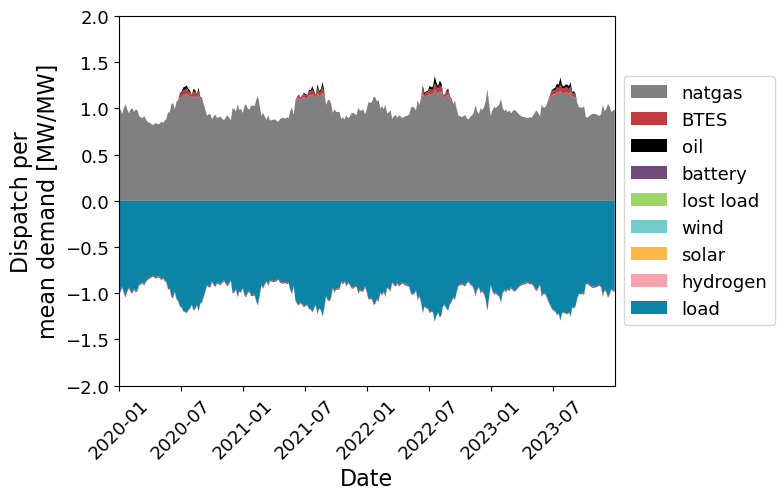

In [69]:
# Plot dispatch and energy stored for BTES
for cost_factor in ['0p99', '1p32', '1p57']:
    var = 'fossil' if not cost_factor == '1p57' else 'renewable'
    data_file = f'output_data/btes_base_case_orca/btes_output_{var}_costsx{cost_factor}.pickle'
    make_storage_plots(data_file, cost_factor, 'conus', f'{var} cost times {cost_factor}')